In [1]:
import numpy as np
import pandas as pd
import email
import codecs
import re
from email.message import EmailMessage
from email.parser import BytesParser, Parser
from email.policy import default
import smtplib
import bs4

import matplotlib.pyplot as plt

%matplotlib inline

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.model_selection import cross_val_score

In [46]:
dir_path = './trec05p-1/'
df = pd.read_csv(dir_path+'full/index',sep=' ',names=['spam','path'])
paths = df.path.apply(lambda x:'./trec05p-1'+x[2:])
email_id = df.path.apply(lambda x:x[8:]) 
spam = df.spam.apply(lambda x:1 if x=='spam' else 0)

In [5]:
def getContent(path):
    raw_email = codecs.open(path, encoding='latin-1', errors='ignore').read()
    msg = email.message_from_string(raw_email)  

    subject = msg['subject']
    if msg.is_multipart():
        parts = 0
        attachments = 0
        body = ''
        links = 0
        for part in msg.walk():
            parts += 1        
            ctype = part.get_content_type()
            if ctype == 'text/html':
                html = 1
            else:
                html = 0        
            if 'attachment' in str(part.get('Content-Disposition')).lower():
                attachments += 1
            if (ctype == 'text/html') | (ctype == 'text/plain'):
                soup = bs4.BeautifulSoup(str(part), 'html.parser')
                body += soup.get_text().replace(',',' ')
                links += len(soup.find_all("a"))
                pattern = 'http://'
                string = body
                links += len(re.findall(pattern,string))

    else:
        parts = 1
        links = 0
        body = msg.get_payload().replace(',',' ')
        if msg.get_content_type() == 'text/html':
            html = 1
        else:
            html = 0
        attachments = 0
        if html == 1:
            soup = bs4.BeautifulSoup(str(body), 'html.parser')
            body = soup.get_text() 
            links += len(soup.find_all("a"))
        pattern = 'http://'
        string = body
        links += len(re.findall(pattern,string))
    row = [parts,attachments,html,subject,body.replace('\n',''),links]  
  
    return row


In [ ]:
DataTable = pd.DataFrame(np.zeros(shape=(len(email_id),8)),columns=['email_id','parts','attachments','html','subject','body','links','spam'])
for i in range(len(paths)):
    p = paths[i]
    row = [email_id[i]] + getContent(p) + [spam[i]]
    DataTable.loc[i,:] = row

In [ ]:
df = DataTable

In [7]:
DataTable.to_csv('emails_05.csv')

In [9]:
df

,email_id,parts,attachments,html,subject,body,links,spam
0,000/000,1.0,0.0,0.0,"FW: June 29 -- BNA, Inc. Daily Labor Report",User ID: enrondlrPW: bnaweb22 -----Ori...,41.0,0.0
1,000/001,1.0,0.0,0.0,NGX failover plan.,"Hi Chris, Tonight we are rolling out a new re...",0.0,0.0
2,000/002,1.0,0.0,0.0,RE: Intranet Site,Rika r these new? -----Original Message-----Fr...,3.0,0.0
3,000/003,1.0,0.0,0.0,FW: ENA Upstream Company information,"John/Gerald,We are currently trading under GTC...",0.0,0.0
4,000/004,1.0,0.0,0.0,New Master Physical,Gerald and Stacy -Attached is a worksheet for ...,0.0,0.0
...,...,...,...,...,...,...,...,...
92184,307/086,3.0,0.0,1.0,=?gb2312?B?c2hvZXMgZnJvbSB3d3cubG92ZWluZmFzaGl...,"Content-Type: text/html;\tcharset=""GB2312""Cont...",0.0,1.0
92185,307/087,3.0,0.0,1.0,=?gb2312?B?c2hvZXMgZnJvbSB3d3cubG92ZWluZmFzaGl...,"Content-Type: text/html;\tcharset=""GB2312""Cont...",0.0,1.0
92186,307/088,3.0,0.0,1.0,=?gb2312?B?c2hvZXMgZnJvbSB3d3cubG92ZWluZmFzaGl...,"Content-Type: text/html;\tcharset=""GB2312""Cont...",0.0,1.0
92187,307/089,3.0,0.0,1.0,=?gb2312?B?c2hvZXMgZnJvbSB3d3cubG92ZWluZmFzaGl...,"Content-Type: text/html;\tcharset=""GB2312""Cont...",0.0,1.0


In [ ]:
df = pd.read_csv('emails_05.csv')

In [7]:
seed=100
np.random.seed(seed)
x_train, x_val, y_train, y_val = train_test_split(df, spam, train_size = 0.85)


# Structural Information Model


In [15]:
x_train.loc[x_train.loc[:,'links'] != 0,'links'] = 1
x_train.loc[x_train.loc[:,'parts'] == 1,'parts'] = 0
x_train.loc[x_train.loc[:,'parts'] != 0,'parts'] = 1
train = x_train.loc[:,['parts','html','links','attachments']]

In [16]:
x_val.loc[x_val.loc[:,'links'] != 0,'links'] = 1
x_val.loc[x_val.loc[:,'parts'] == 1,'parts'] = 0
x_val.loc[x_val.loc[:,'parts'] != 0,'parts'] = 1
val = x_val.loc[:,['parts','html','links','attachments']]

In [17]:
model = MultinomialNB()
model.fit(train, y_train)
np.mean(model.predict(train) == y_train), np.mean(model.predict(val) == y_val)

(0.5871372549019608, 0.5858698067096201)

In [18]:
score1 = cross_val_score(model,train,y_train,cv=5,scoring='roc_auc')
auc1=score1.mean()
print("AUC",auc1)

AUC 0.8740406145276582


# Subject Model

In [21]:
cv = CountVectorizer()
train2 = cv.fit_transform(np.array([' ' if x is None else x for x in x_train.loc[:,'subject']]))
val2 = cv.transform(np.array([' ' if x is None else x for x in x_val.loc[:,'subject']]))

model = MultinomialNB()
model.fit(train2, y_train)
np.mean(model.predict(train2) == y_train)



0.945921568627451

In [22]:
y_pred2 = model.predict(val2)
accuracy = np.mean(y_pred2 == y_val)
accuracy

0.9313485892023995

In [23]:
score2 = cross_val_score(model,train2,y_train,cv=5,scoring='roc_auc')
auc2=score2.mean()
print("AUC",auc2)

AUC 0.9768029490364819


# Message Body Model

In [25]:
cv = CountVectorizer()
train3 = cv.fit_transform(np.array([' ' if x is None else x for x in x_train.loc[:,'body']]))
val3 = cv.transform(np.array([' ' if x is None else x for x in x_train.loc[:,'body']]))

model = MultinomialNB()
model.fit(train3, y_train)
np.mean(model.predict(train3) == y_train)

0.945764705882353

In [27]:
score3 = cross_val_score(model,train3,y_train,cv=5,scoring='roc_auc')
auc3=score3.mean()
print("AUC",auc3)

AUC 0.9804669224276548


# Own Model

In [14]:
from sklearn.naive_bayes import GaussianNB
gaussian_model=GaussianNB()
gaussian_model.fit(train,y_train)

train_acc=np.mean(gaussian_model.predict(train)==y_train)
print("train accuracy",train_acc)


train accuracy 0.8128470588235294


In [16]:
score4 = cross_val_score(gaussian_model,train,y_train,cv=5,scoring='roc_auc')
auc4=score4.mean()
print("AUC",auc4)

AUC 0.8625554972482499


# Combined Model

In [39]:
cv = CountVectorizer()
sub = [' ' if x is None else x for x in x_train.loc[:,'subject']] 
body = [' ' if x is None else x for x in x_train.loc[:,'body']]
com = []
for i in range(len(body)):
    com.append(str(sub[i]) + str(body[i])) 
train5 = cv.fit_transform(np.array(com))


model = MultinomialNB()
model.fit(train5, y_train)
np.mean(model.predict(train5) == y_train)


0.9631372549019608

In [44]:
score5 = cross_val_score(model,train5,y_train,cv=5,scoring='roc_auc')
auc5=score5.mean()
print("AUC",auc5)

AUC 0.9854178667855515


# Select Model

By the AUC we calculated above, the Combined Model has the best performance 

In [19]:
#structual
df.loc[df.loc[:,'links'] != 0,'links'] = 1
df.loc[df.loc[:,'parts'] == 1,'parts'] = 0
df.loc[df.loc[:,'parts'] != 0,'parts'] = 1
data_stru = df.loc[:,['parts','html','links','attachments']]

model = MultinomialNB()
model.fit(data_stru, spam)
score1 = cross_val_score(model,data_stru,spam,cv=5,scoring='roc_auc')
auc1=score1.mean()
print("Structural Information Model AUC",auc1)

Structural Information Model AUC 0.6062716361513727


Text(0, 0.5, 'True Positive Rate')

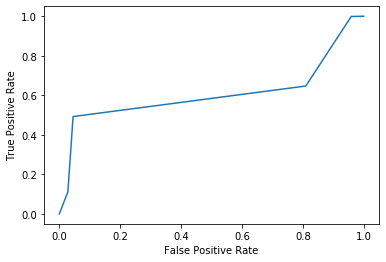

In [21]:
set_prob=model.predict_proba(data_stru)[:,1]
set_fpr,set_tpr,set_threshold=roc_curve(spam,set_prob)
plt.plot(set_fpr,set_tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [50]:
#subject
cv = CountVectorizer()
data = cv.fit_transform(np.array([' ' if x is None else x for x in df.loc[:,'subject']]))

model = MultinomialNB()
model.fit(data, spam)

score2 = cross_val_score(model,data,spam,cv=5,scoring='roc_auc')
auc2=score2.mean()
print("Subject Model AUC",auc2)

Subject Model AUC 0.9632042497258448


Text(0, 0.5, 'True Positive Rate')

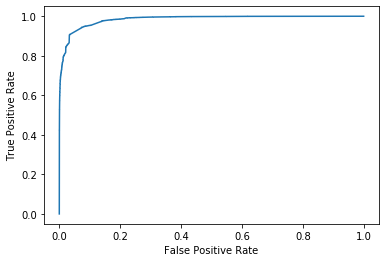

In [53]:
set_prob=model.predict_proba(data)[:,1]
set_fpr,set_tpr,set_threshold=roc_curve(spam,set_prob)
plt.plot(set_fpr,set_tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [57]:
#body
cv = CountVectorizer()
data = cv.fit_transform(np.array([' ' if x is None else x for x in df.loc[:,'body']]))
model = MultinomialNB()
model.fit(data, spam)

score3 = cross_val_score(model,data,spam,cv=5,scoring='roc_auc')
auc3=score3.mean()
print("Body Model AUC",auc3)

Body Model AUC 0.9703462183541884


Text(0, 0.5, 'True Positive Rate')

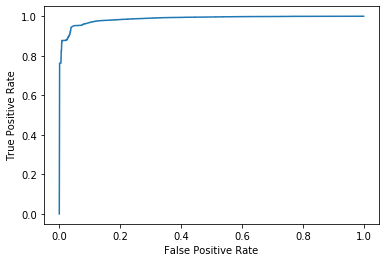

In [58]:
set_prob=model.predict_proba(data)[:,1]
set_fpr,set_tpr,set_threshold=roc_curve(spam,set_prob)
plt.plot(set_fpr,set_tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [59]:
#Combined
cv = CountVectorizer()
sub = [' ' if x is None else x for x in df.loc[:,'subject']] 
body = [' ' if x is None else x for x in df.loc[:,'body']]
com = []
for i in range(len(body)):
    com.append(str(sub[i]) + str(body[i])) 
data = cv.fit_transform(np.array(com))


model = MultinomialNB()
model.fit(data, spam)

score5 = cross_val_score(model,data,spam,cv=5,scoring='roc_auc')
auc5=score5.mean()
print("Combined Model AUC",auc5)

Combined Model AUC 0.9766818589549334


Text(0, 0.5, 'True Positive Rate')

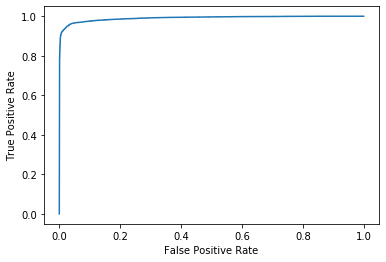

In [60]:
set_prob=model.predict_proba(data)[:,1]
set_fpr,set_tpr,set_threshold=roc_curve(spam,set_prob)
plt.plot(set_fpr,set_tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# TREC 2006 Analysis

In [7]:
dir_path06 = './trec06p/'
df06 = pd.read_csv(dir_path06+'full/index',sep=' ',names=['spam','path'])
paths06 = df06.path.apply(lambda x:'./trec06p'+x[2:])
email_id06 = df06.path.apply(lambda x:x[8:]) 
spam06 = df06.spam.apply(lambda x:1 if x=='spam' else 0)

In [13]:
DataTable06 = pd.DataFrame(np.zeros(shape=(len(email_id06),8)),columns=['email_id','parts','attachments','html','subject','body','links','spam'])
for i in range(len(paths06)):
    p = paths06[i]
    row = [email_id06[i]] + getContent(p) + [spam06[i]]
    DataTable06.loc[i,:] = row

In [77]:
DataTable06

,email_id,parts,attachments,html,subject,body,links,spam
0,000/000,1.0,0.0,0.0,new Catholic mailing list now up and running,The mailing list I queried about a few weeks a...,0.0,0.0
1,000/001,2.0,0.0,0.0,re[12]:,Content-Type: text/plain;Content-Transfer-Enco...,1.0,1.0
2,000/002,1.0,0.0,0.0,Take a moment to explore this.,Academic Qualifications available from prestig...,0.0,1.0
3,000/003,1.0,0.0,0.0,Greetings,Greetings all. This is to verify your subscri...,0.0,0.0
4,000/004,3.0,0.0,1.0,LOANS @ 3.17% (27 term),Content-Type: text/html; charset=ISO-8859-1Con...,1.0,1.0
...,...,...,...,...,...,...,...,...
37817,126/017,1.0,0.0,0.0,RE: Watcher daily news,Great News Expec ted!Infinex Ventures Inc. (IN...,0.0,1.0
37818,126/018,1.0,0.0,0.0,RE: Number 1 market Picks,The OIL sector is going crazy. This is our wee...,0.0,1.0
37819,126/019,1.0,0.0,0.0,All products for your health!,http://vdtobj.docscan.info/?23759301Suffering ...,2.0,1.0
37820,126/020,1.0,0.0,0.0,"Its here, now.",U N I V E R S I T Y D I P L O M A SDo you wan...,0.0,1.0


In [14]:
df06 = DataTable06

In [15]:
DataTable06.to_csv('emails_06.csv')

In [11]:
#structual
df06.loc[df06.loc[:,'links'] != 0,'links'] = 1
df06.loc[df06.loc[:,'parts'] == 1,'parts'] = 0
df06.loc[df06.loc[:,'parts'] != 0,'parts'] = 1
data_stru = df06.loc[:,['parts','html','links','attachments']]

model = MultinomialNB()
model.fit(data_stru, spam06)
score1 = cross_val_score(model,data_stru,spam06,cv=5,scoring='roc_auc')
auc1=score1.mean()
print("Structural Information Model AUC",auc1)

Structural Information Model AUC 0.6246525730180867


Text(0, 0.5, 'True Positive Rate')

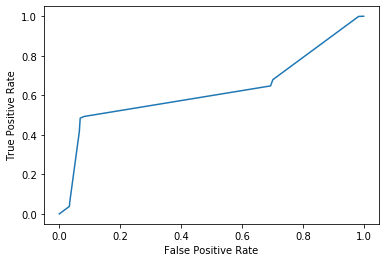

In [13]:
set_prob=model.predict_proba(data_stru)[:,1]
set_fpr,set_tpr,set_threshold=roc_curve(spam06,set_prob)
plt.plot(set_fpr,set_tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [16]:
#subject
cv = CountVectorizer()
data = cv.fit_transform(np.array([' ' if x is None else x for x in df06.loc[:,'subject']]))

model = MultinomialNB()
model.fit(data, spam06)

score2 = cross_val_score(model,data,spam06,cv=5,scoring='roc_auc')
auc2=score2.mean()
print("Subject Model AUC",auc2)

Subject Model AUC 0.9847768425468585


Text(0, 0.5, 'True Positive Rate')

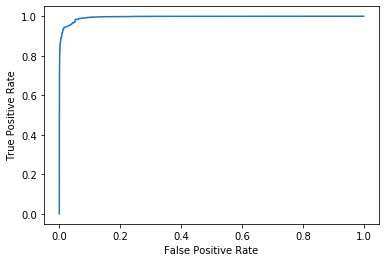

In [17]:
set_prob=model.predict_proba(data)[:,1]
set_fpr,set_tpr,set_threshold=roc_curve(spam06,set_prob)
plt.plot(set_fpr,set_tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [1]:
#body
cv = CountVectorizer()
data = cv.fit_transform(np.array([' ' if x is None else x for x in df06.loc[:,'body']]))
model = MultinomialNB()
model.fit(data, spam06)

score3 = cross_val_score(model,data,spam06,cv=5,scoring='roc_auc')
auc3=score3.mean()
print("Body Model AUC",auc3)

NameError: name 'CountVectorizer' is not defined

In [ ]:
set_prob=model.predict_proba(data)[:,1]
set_fpr,set_tpr,set_threshold=roc_curve(spam06,set_prob)
plt.plot(set_fpr,set_tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [ ]:
#Combined
cv = CountVectorizer()
sub = [' ' if x is None else x for x in df06.loc[:,'subject']] 
body = [' ' if x is None else x for x in df06.loc[:,'body']]
com = []
for i in range(len(body)):
    com.append(str(sub[i]) + str(body[i])) 
data = cv.fit_transform(np.array(com))
model = MultinomialNB()
model.fit(df06, spam06)

score = cross_val_score(model,df06,spam06,cv=5,scoring='roc_auc')
auc=score.mean()
print("Combined Model AUC",auc)

In [ ]:
set_prob=model.predict_proba(data)[:,1]
set_fpr,set_tpr,set_threshold=roc_curve(spam,set_prob)
plt.plot(set_fpr,set_tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")